In [ ]:
# This code is for our Plot2's recreation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

# Define parameters
class Parameters:
    def __init__(self):
        # Base mutation rate per base pair per year
        self.u = 1.25e-8
        
        # Number of driver positions in each gene
        self.n_APC = 604
        self.n_TP53 = 73
        self.n_KRAS = 20       # why=20???
        
        # Mutation rates per year
        self.r_APC = self.n_APC * self.u
        self.r_TP53 = self.n_TP53 * self.u
        self.r_KRAS = self.n_KRAS * self.u
        self.r_LOH = 1.36e-4
        
        # Growth rates per year
        self.b_APC = 0.2    # APC-/- growth rate
        self.b_KRAS = 0.07  # KRAS+ growth rate
        self.b_BOTH = 0.27  # Combined APC-/-,KRAS+ growth rate
        
        # Initial number of crypts
        self.N_crypts = 10**8

In [2]:
def create_transition_matrix(params):
    """Create 32x32 transition rate matrix"""
    n = 32
    T = np.zeros((n, n))
    
    def state_to_idx(apc, tp53, kras):
        return apc * 8 + tp53 * 2 + kras
    
    # APC transitions
    for tp53 in range(4):
        for kras in range(2):
            # APC: (0) -> (1) or (2)
            T[state_to_idx(0, tp53, kras), state_to_idx(1, tp53, kras)] = params.r_LOH
            T[state_to_idx(0, tp53, kras), state_to_idx(2, tp53, kras)] = params.r_APC
            
            # APC: (1) -> (3)
            T[state_to_idx(1, tp53, kras), state_to_idx(3, tp53, kras)] = params.r_APC/2
            
            # APC: (2) -> (3)
            T[state_to_idx(2, tp53, kras), state_to_idx(3, tp53, kras)] = params.r_LOH/2
    
    # TP53 transitions
    for apc in range(4):
        for kras in range(2):
            # TP53: (0) -> (1) or (2)
            T[state_to_idx(apc, 0, kras), state_to_idx(apc, 1, kras)] = params.r_LOH
            T[state_to_idx(apc, 0, kras), state_to_idx(apc, 2, kras)] = params.r_TP53
            
            # TP53: (1) -> (3)
            T[state_to_idx(apc, 1, kras), state_to_idx(apc, 3, kras)] = params.r_TP53/2
            
            # TP53: (2) -> (3)
            T[state_to_idx(apc, 2, kras), state_to_idx(apc, 3, kras)] = params.r_LOH/2
    
    # KRAS transitions
    for apc in range(4):
        for tp53 in range(4):
            # KRAS: (0) -> (1)
            T[state_to_idx(apc, tp53, 0), state_to_idx(apc, tp53, 1)] = params.r_KRAS
            
    return T

In [3]:
def create_growth_matrix(params):
    """Create 32x32 diagonal growth rate matrix"""
    n = 32
    G = np.zeros((n, n))
    
    def state_to_idx(apc, tp53, kras):
        return apc * 8 + tp53 * 2 + kras
    
    # Fill diagonal with growth rates
    for apc in range(4):
        for tp53 in range(4):
            for kras in range(2):
                idx = state_to_idx(apc, tp53, kras)
                
                if apc >= 3:  # APC-/- states
                    if kras == 1:  # APC-/- + KRAS+
                        G[idx, idx] = params.b_BOTH
                    else:  # Only APC-/-
                        G[idx, idx] = params.b_APC
                elif kras == 1:  # KRAS+ only
                    G[idx, idx] = params.b_KRAS
                
    return G

In [4]:
def simulate_evolution(params, t_max=80, dt=0.1):
    """Simulate the evolution of crypts using matrix approach"""
    # Create matrices
    T = create_transition_matrix(params)
    G = create_growth_matrix(params)
    
    # # Output the transition matrix T and growth matrix G
    # print("Transition Matrix (T):")
    # print(T)
    # print("\nGrowth Matrix (G):")
    # print(G)
    
    # Time points
    times = np.arange(0, t_max + dt, dt)
    
    # Initialize state vector (all crypts in state 000)
    v = np.zeros(32)
    v[0] = params.N_crypts
    
    # Store results
    results = np.zeros(len(times))
    malignant_idx = 3*8 + 3*2 + 1  # Index for state (3,3,1)
    
    # Evolution
    for i, t in enumerate(times):
        # Store malignant probability
        # results[i] = v[malignant_idx] / params.N_crypts
        results[i] = v[malignant_idx] 
        
        # Update state vector
        v = v + (np.matmul(v, T) + np.matmul(v, G)) * dt
        
    return times, results

Running simulation...
Plotting results...


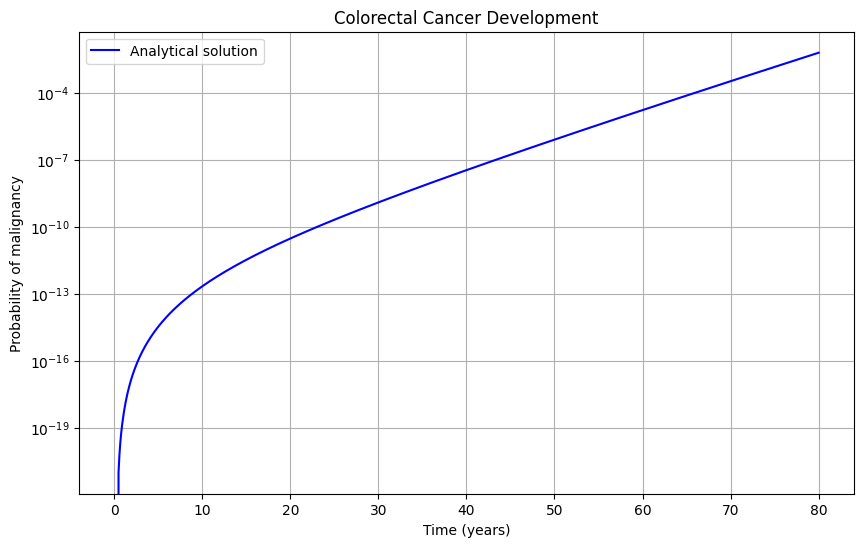

In [5]:
def plot_results(times, probs):
    """Plot results on semi-log scale"""
    plt.figure(figsize=(10, 6))
    plt.semilogy(times, probs, 'b-', label='Analytical solution')
    plt.xlabel('Time (years)')
    plt.ylabel('Probability of malignancy')
    plt.title('Colorectal Cancer Development')
    plt.grid(True)
    plt.legend()
    plt.show()

def print_state_mapping():
    """Print mapping between indices and states"""
    print("Index -> State mapping:")
    for apc in range(4):
        for tp53 in range(4):
            for kras in range(2):
                idx = apc * 8 + tp53 * 2 + kras
                print(f"Index {idx:2d}: ({apc},{tp53},{kras})")

if __name__ == "__main__":
    # Initialize parameters
    params = Parameters()
    
    # Run simulation
    print("Running simulation...")
    times, probs = simulate_evolution(params, t_max=80, dt=0.1)
    
    # Plot results
    print("Plotting results...")
    plot_results(times, probs)


Running simulation...
Plotting results...


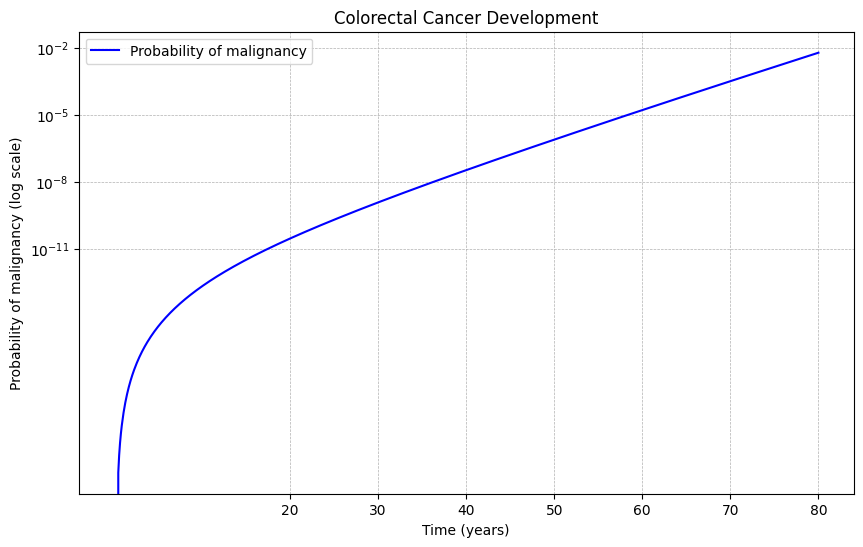

In [ ]:
# start w/ 20yrs
def plot_results(times, probs):
    """Plot results with specified x and y-axis ticks and labels"""
    plt.figure(figsize=(10, 6))
    
    # Plot the data
    plt.plot(times, probs, 'b-', label='Probability of malignancy')
    
    # Set logarithmic scale for y-axis
    plt.yscale("log")
    
    # Set x-axis ticks
    plt.xticks([20, 30, 40, 50, 60, 70, 80])
    
    # Set y-axis ticks and labels
    y_ticks = [1e-11, 1e-8, 1e-5, 1e-2]  # 10^-11, 10^-8, 10^-5, 0.01
    y_labels = [r"$10^{-11}$", r"$10^{-8}$", r"$10^{-5}$", r"$10^{-2}$"]
    plt.yticks(y_ticks, y_labels)
    
    # Add labels, title, and grid
    plt.xlabel('Time (years)')
    plt.ylabel('Probability of malignancy (log scale)')
    plt.title('Colorectal Cancer Development')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Initialize parameters
    params = Parameters()
    
    # Run simulation
    print("Running simulation...")
    times, probs = simulate_evolution(params, t_max=80, dt=0.1)
    
    # Plot results
    print("Plotting results...")
    plot_results(times, probs)


Running simulation...
Plotting results...


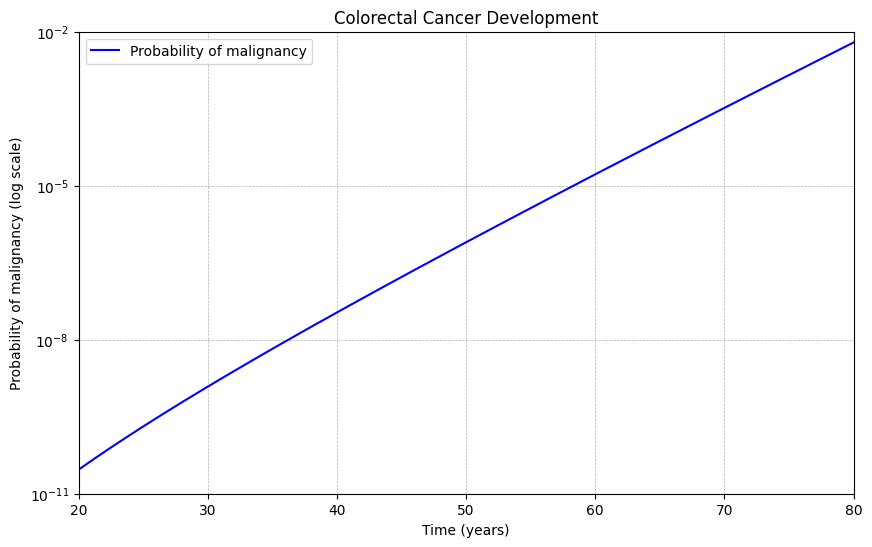

Probability of malignancy at 80 years: 6.194e-03


In [13]:
def plot_results(times, probs):
    """Plot results with specified x and y-axis ticks, and truncate x-axis below 20"""
    plt.figure(figsize=(10, 6))
    
    # Plot the data
    plt.plot(times, probs, 'b-', label='Probability of malignancy')
    
    # Set logarithmic scale for y-axis
    plt.yscale("log")
    
    # Set x-axis range and ticks
    plt.xlim(20, 80)  # Start at 20 and end at 80
    plt.xticks([20, 30, 40, 50, 60, 70, 80])
    
    # Set y-axis range and ticks
    plt.ylim(1e-11, 1e-2)  # Start y-axis at 10^-11
    y_ticks = [1e-11, 1e-8, 1e-5, 1e-2]  # 10^-11, 10^-8, 10^-5, 0.01
    y_labels = [r"$10^{-11}$", r"$10^{-8}$", r"$10^{-5}$", r"$10^{-2}$"]
    plt.yticks(y_ticks, y_labels)
    
    # Add labels, title, and grid
    plt.xlabel('Time (years)')
    plt.ylabel('Probability of malignancy (log scale)')
    plt.title('Colorectal Cancer Development')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Initialize parameters
    params = Parameters()
    
    # Run simulation
    print("Running simulation...")
    times, probs = simulate_evolution(params, t_max=80, dt=0.1)
    
    # Plot results
    print("Plotting results...")
    plot_results(times, probs)
    
    # Output the probability at 80 years
    print(f"Probability of malignancy at 80 years: {probs[-1]:.3e}")


Simulating Equation 1...
Plotting Equation 1...


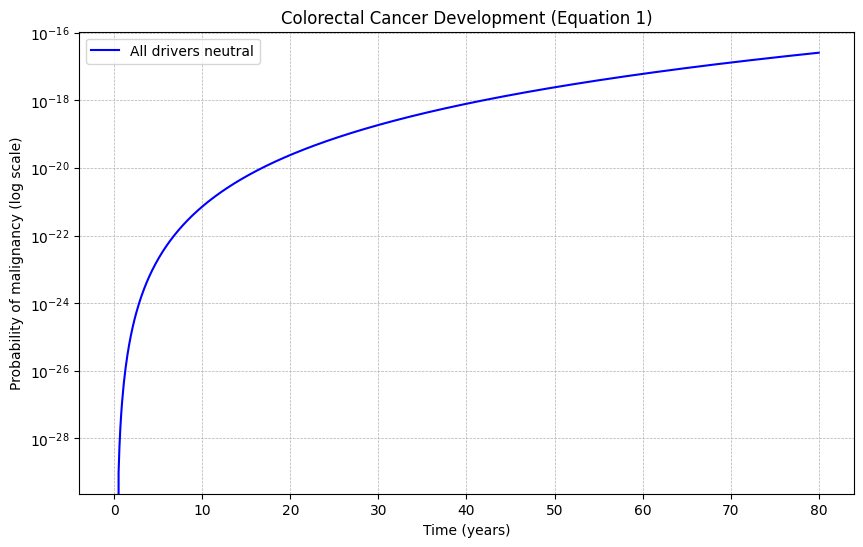

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
class Parameters:
    def __init__(self):
        # Base mutation rate per base pair per year
        self.u = 1.25e-8
        
        # Number of driver positions in each gene
        self.n_APC = 604
        self.n_TP53 = 73
        self.n_KRAS = 20
        
        # Mutation rates per year
        self.r_APC = self.n_APC * self.u
        self.r_TP53 = self.n_TP53 * self.u
        self.r_KRAS = self.n_KRAS * self.u
        self.r_LOH = 1.36e-4
        
        # Growth rates per year
        self.b_APC = 0.2    # APC-/- growth rate
        self.b_KRAS = 0.07  # KRAS+ growth rate
        self.b_BOTH = 0.27  # Combined APC-/-,KRAS+ growth rate
        
        # Initial number of crypts
        self.N_crypts = 10**8

def create_transition_matrix(params):
    """Create 32x32 transition rate matrix"""
    n = 32
    T = np.zeros((n, n))
    
    def state_to_idx(apc, tp53, kras):
        return apc * 8 + tp53 * 2 + kras
    
    # APC transitions
    for tp53 in range(4):
        for kras in range(2):
            T[state_to_idx(0, tp53, kras), state_to_idx(1, tp53, kras)] = params.r_LOH
            T[state_to_idx(0, tp53, kras), state_to_idx(2, tp53, kras)] = params.r_APC
            T[state_to_idx(1, tp53, kras), state_to_idx(3, tp53, kras)] = params.r_APC / 2
            T[state_to_idx(2, tp53, kras), state_to_idx(3, tp53, kras)] = params.r_LOH / 2
    
    # TP53 transitions
    for apc in range(4):
        for kras in range(2):
            T[state_to_idx(apc, 0, kras), state_to_idx(apc, 1, kras)] = params.r_LOH
            T[state_to_idx(apc, 0, kras), state_to_idx(apc, 2, kras)] = params.r_TP53
            T[state_to_idx(apc, 1, kras), state_to_idx(apc, 3, kras)] = params.r_TP53 / 2
            T[state_to_idx(apc, 2, kras), state_to_idx(apc, 3, kras)] = params.r_LOH / 2
    
    # KRAS transitions
    for apc in range(4):
        for tp53 in range(4):
            T[state_to_idx(apc, tp53, 0), state_to_idx(apc, tp53, 1)] = params.r_KRAS
            
    return T

def create_growth_matrix_neutral():
    """Create a 32x32 diagonal growth rate matrix for neutral case"""
    n = 32
    G = np.zeros((n, n))  # All drivers neutral, no growth advantage
    return G

def simulate_evolution(params, t_max=80, dt=0.1):
    """Simulate the evolution of crypts using matrix approach"""
    # Create matrices
    T = create_transition_matrix(params)
    G = create_growth_matrix_neutral()  # Neutral case: no growth advantage
    
    # Time points
    times = np.arange(0, t_max + dt, dt)
    
    # Initialize state vector (all crypts in state 000)
    v = np.zeros(32)
    v[0] = params.N_crypts
    
    # Store results
    results = np.zeros(len(times))
    malignant_idx = 3*8 + 3*2 + 1  # Index for state (3,3,1)
    
    # Evolution
    for i, t in enumerate(times):
        # Store malignant probability
        results[i] = v[malignant_idx] / params.N_crypts
        # Update state vector
        v = v + (np.matmul(v, T) + np.matmul(v, G)) * dt
        
    return times, results

def plot_results(times, probs):
    """Plot results on semi-log scale"""
    plt.figure(figsize=(10, 6))
    plt.semilogy(times, probs, 'b-', label='All drivers neutral')
    plt.xlabel('Time (years)')
    plt.ylabel('Probability of malignancy (log scale)')
    plt.title('Colorectal Cancer Development (Equation 1)')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Initialize parameters
    params = Parameters()
    
    # Simulate for Equation 1 (all drivers neutral)
    print("Simulating Equation 1...")
    times, probs = simulate_evolution(params, t_max=80, dt=0.1)
    
    # Plot the results
    print("Plotting Equation 1...")
    plot_results(times, probs)
